In [1]:
  import tweepy as tw
import pandas as pd
import re
import numpy as np
import string
from gensim.models import Word2Vec

#Keys and Access Tokens
consumer_key  = 'EvuOfyZFkcWPdT9sd7H5PKNRV'
consumer_secret = 'CtsmQR05FHuIz0oDgkXQFUI9Iqvazzue6zKuXqed8htIc7iwDd'
access_token = '1599614659434545152-aZ9BNeajhD3Sv1xRsU7x8Ioxj1wN0R'
access_token_secret = 'MYMrQ1I8rxuPuUPieP9XgaeXGu0DcN36bUFi22saCe8pT'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [2]:
def search_tweets(language, hashtag, date, number):
  #Define
  search_words = hashtag
  date_since = date
  new_search = search_words + " -filter:retweets"

  #Collect
  tweets = tw.Cursor(api.search, q=new_search, lang=language, since=date_since).items(number)
  users_locs = [[tweet.created_at, clean_text(tweet.text), tweet.user.followers_count,tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

  #Dataframe
  tweet_df = pd.DataFrame(data=users_locs, columns=["time_stamp", "text", "followers_count", "retweet_count", "favorite_count"])

  return tweet_df

In [3]:
def clean_text(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    clean_emoji = emoji_pattern.sub(r'', string)
    clean_hastag = re.sub("#[A-Za-z0-9_]+","", clean_emoji)
    clean_mention = re.sub("@[A-Za-z0-9_]+","", clean_hastag)
    clean_URL = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', clean_mention)
    return clean_URL

In [4]:
df = search_tweets('en', '#wednesdaynetflix', '2022-11-23', 1000)
df.to_csv(r'wednesdaynetflix.csv', encoding='utf-8-sig', index = False)

display(df)

,time_stamp,text,followers_count,retweet_count,favorite_count
0,2023-01-27 12:12:29,the most satisfying thing I ve seen this year....,697,0,0
1,2023-01-27 12:08:55,Jenna Ortega with her fan Wednesday \n …,43,0,1
2,2023-01-27 11:44:54,looks to set records! Here’s the latest air...,20556,0,0
3,2023-01-27 11:21:08,el stalker de wednesday-,370,0,0
4,2023-01-27 11:06:35,Yes and I'll draw Wednesday in gf's this pose ...,2,0,0
...,...,...,...,...,...
995,2023-01-19 03:25:46,"My God, this is incredibly perfect!",5,0,25
996,2023-01-19 03:13:25,Enid!! got any ideas for me to draw wolf Enid ...,1315,15,251
997,2023-01-19 02:48:54,Drawing this was fun\n\n,392,38,475
998,2023-01-19 02:46:34,Watching,168,0,1


In [5]:
df = pd.read_csv('wednesdaynetflix.csv')

In [6]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy

# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

def is_space(text):
  if text == '':
    return 'Good'
  else:
    return text

In [7]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
import nltk
import nltk.data
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
nltk.download('punkt')
nltk.download('stopwords')

df['new_text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['new_text'] = df['new_text'].str.replace('[^\w\s]','')
df['new_text'] = df['new_text'].apply(lambda x: clean_text(x))

stop = stopwords.words('english')
df['new_text'] = df['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['new_text'] = df['new_text'].apply(space)
df['new_text'] = df['new_text'].apply(is_space)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-7-a644498dcd69>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_text'] = df['new_text'].str.replace('[^\w\s]','')


In [8]:
texts = df["new_text"].values.tolist()
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

for i in range(len(texts)) :
  ls =  tknzr.tokenize(texts[i])
  texts[i] = ls
print(texts)
display(texts)

[['satisfy', 'thing', 'see', 'year'], ['jenna', 'ortega', 'fan', 'wednesday'], ['look', 'set', 'record', 'here', 'late', 'airplay', 'stat', 'yes', 'work'], ['el', 'stalker', 'de', 'wednesday'], ['yes', 'ill', 'draw', 'wednesday', 'gfs', 'pose', 'hit', '11', 'like'], ['I', 'm', 'gay'], ['wednesday', 'addam', 'understand', 'unique', 'level', 'where', 's', 'lie'], ['jennys', 'hairstyle', 'wednesday', 'dance'], ['wednesday', 'ha', 'llorado', 'con', 'la', 'casi', 'muerte', 'de', 'thing'], ['wednesday', 'tylergtgtgtgtgt'], ['xavier', 'know'], ['who', 's', 'hot', 'man'], ['hope', 'happen'], ['dayum'], ['heart', 'hurt', 'please', 'give', 'back'], ['love', 'addam', 'family', 'meet', 'harry', 'potter', 'meet', 'sherlock', 'holmes', 'snap', 'snap'], ['recent', 'drawing', 'video', 'link'], ['wednesday', 'writer', 'block', 'new', 'feeling', 'enid', 'she', 's', 'unconsciously', 'repress', 'get'], ['mysterious', 'spooky', 'paint', 'truly', 'side', 'note', 'really', 'hope', 'get', 'see', 'ophelia'], [

[['satisfy', 'thing', 'see', 'year'],
 ['jenna', 'ortega', 'fan', 'wednesday'],
 ['look', 'set', 'record', 'here', 'late', 'airplay', 'stat', 'yes', 'work'],
 ['el', 'stalker', 'de', 'wednesday'],
 ['yes', 'ill', 'draw', 'wednesday', 'gfs', 'pose', 'hit', '11', 'like'],
 ['I', 'm', 'gay'],
 ['wednesday', 'addam', 'understand', 'unique', 'level', 'where', 's', 'lie'],
 ['jennys', 'hairstyle', 'wednesday', 'dance'],
 ['wednesday', 'ha', 'llorado', 'con', 'la', 'casi', 'muerte', 'de', 'thing'],
 ['wednesday', 'tylergtgtgtgtgt'],
 ['xavier', 'know'],
 ['who', 's', 'hot', 'man'],
 ['hope', 'happen'],
 ['dayum'],
 ['heart', 'hurt', 'please', 'give', 'back'],
 ['love',
  'addam',
  'family',
  'meet',
  'harry',
  'potter',
  'meet',
  'sherlock',
  'holmes',
  'snap',
  'snap'],
 ['recent', 'drawing', 'video', 'link'],
 ['wednesday',
  'writer',
  'block',
  'new',
  'feeling',
  'enid',
  'she',
  's',
  'unconsciously',
  'repress',
  'get'],
 ['mysterious',
  'spooky',
  'paint',
  'truly

In [9]:
model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

best_vocabs = set()
for text in texts :
  best_vocabs = best_vocabs.union(set(text))

#แสดงคำศัพท์ทั้งหมด
display(model.wv.vocab)

{'satisfy': <gensim.models.keyedvectors.Vocab at 0x7f0d012014f0>,
 'thing': <gensim.models.keyedvectors.Vocab at 0x7f0d01201520>,
 'see': <gensim.models.keyedvectors.Vocab at 0x7f0d012015e0>,
 'year': <gensim.models.keyedvectors.Vocab at 0x7f0d01201550>,
 'jenna': <gensim.models.keyedvectors.Vocab at 0x7f0d01201430>,
 'ortega': <gensim.models.keyedvectors.Vocab at 0x7f0d182d96d0>,
 'fan': <gensim.models.keyedvectors.Vocab at 0x7f0d182d9820>,
 'wednesday': <gensim.models.keyedvectors.Vocab at 0x7f0d182d9670>,
 'look': <gensim.models.keyedvectors.Vocab at 0x7f0d182d9340>,
 'set': <gensim.models.keyedvectors.Vocab at 0x7f0d182e55b0>,
 'record': <gensim.models.keyedvectors.Vocab at 0x7f0d182e5250>,
 'here': <gensim.models.keyedvectors.Vocab at 0x7f0d182e52b0>,
 'late': <gensim.models.keyedvectors.Vocab at 0x7f0d182e5400>,
 'airplay': <gensim.models.keyedvectors.Vocab at 0x7f0d182e5280>,
 'stat': <gensim.models.keyedvectors.Vocab at 0x7f0d0127c370>,
 'yes': <gensim.models.keyedvectors.Vocab

In [10]:
model.build_vocab(texts, update=True)
print(len(model.wv.vocab))

2031


In [11]:
display(df)

,time_stamp,text,followers_count,retweet_count,favorite_count,new_text
0,2023-01-27 12:12:29,the most satisfying thing I ve seen this year....,697,0,0,satisfy thing see year
1,2023-01-27 12:08:55,Jenna Ortega with her fan Wednesday \n …,43,0,1,jenna ortega fan wednesday
2,2023-01-27 11:44:54,looks to set records! Here’s the latest air...,20556,0,0,look set record here late airplay stat yes work
3,2023-01-27 11:21:08,el stalker de wednesday-,370,0,0,el stalker de wednesday
4,2023-01-27 11:06:35,Yes and I'll draw Wednesday in gf's this pose ...,2,0,0,yes ill draw wednesday gfs pose hit 11 like
...,...,...,...,...,...,...
995,2023-01-19 03:25:46,"My God, this is incredibly perfect!",5,0,25,god incredibly perfect
996,2023-01-19 03:13:25,Enid!! got any ideas for me to draw wolf Enid ...,1315,15,251,enid get idea draw wolf enid stuff wenclair wo...
997,2023-01-19 02:48:54,Drawing this was fun\n\n,392,38,475,draw fun
998,2023-01-19 02:46:34,Watching,168,0,1,watch


In [12]:
import nltk
from statistics import mean
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def is_positive(text) -> bool:
    scores = [
        sia.polarity_scores(sentence)["compound"]
        for sentence in nltk.sent_tokenize(text)
    ]
    return mean(scores) > 0


df['sentiment'] = df.new_text.apply(is_positive)
# is_positive("Wow, NLTK is really powerful!")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [13]:
word2id = {w:i.index for w,i in model.wv.vocab.items()}
label2id = {True:0, False:1}

In [14]:
df['word_ids'] = df.new_text.apply(lambda sentence:[word2id[word] for word in tknzr.tokenize(sentence)])
df['label_id'] = df.sentiment.apply(lambda label:label2id[label])

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df[['new_text', 'word_ids', 'label_id']], test_size=0.2, random_state=10)

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = len(model.wv.vocab)
embedding_dim = 100
max_length = 128

train_padded = pad_sequences(train_set.word_ids, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_set.word_ids, maxlen=max_length, padding='post', truncating='post')

In [17]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model_lstm.summary()
history_lstm = model_lstm.fit(train_padded, 
                    train_set.label_id, 
                    validation_data=(test_padded, test_set.label_id), 
                    epochs=10, 
                    verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          203100    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 238,733
Trainable params: 238,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 - 8s - loss: 0.6750 - accuracy: 0.5738 - val_loss: 0.6591 - val_accuracy: 0.5700 - 8s/epoch - 304ms

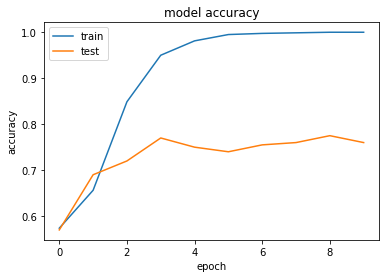

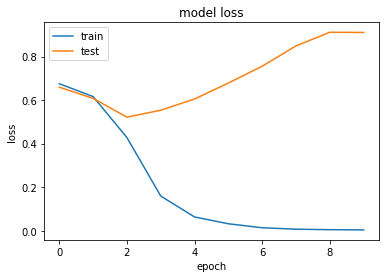

In [18]:
import matplotlib.pyplot as plt
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
display(train_set)

,new_text,word_ids,label_id
188,second illustration inspire dedicated wednesda...,"[242, 1033, 209, 1034, 0, 17, 1035]",0
194,light torture do not worry will not leave mark,"[243, 562, 10, 1, 361, 384, 1, 332, 563]",1
225,jan 24 stressful pple around stress lol go wal...,"[582, 1076, 1077, 1078, 157, 1079, 208, 8, 583...",1
580,anna never say father meet work netf,"[1512, 78, 61, 676, 183, 69, 1513]",1
428,know wattpad go crazy fanfic wednesday enid lol,"[21, 1314, 8, 439, 670, 0, 3, 208]",0
...,...,...,...
320,watch netflix series base life wednesday addam...,"[4, 34, 25, 627, 410, 0, 17, 17, 56, 136]",1
527,remove percy hyne white wednesday cast sign pe...,"[448, 54, 1447, 163, 0, 97, 1448, 1449, 58]",1
996,enid get idea draw wolf enid stuff wenclair wo...,"[3, 7, 120, 11, 297, 3, 790, 30, 38, 133, 41]",0
125,something today,"[169, 174]",1


In [20]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, confusion_matrix

tfidf_vectorizer = TfidfVectorizer()

def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['new_text'])
    
    X = np.array(tfidf_vectorizer.transform(df['new_text']).todense())
    return X

In [21]:
clf = MultinomialNB(alpha=0.1)
X_train = feature_extraction(train_set)
y_train = train_set['label_id'].values

X_test = feature_extraction(test_set, test=True)
y_test = test_set['label_id'].values

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.808695652173913
Confusion matrix:


array([[63, 21],
       [23, 93]])

In [22]:
display(df)

,time_stamp,text,followers_count,retweet_count,favorite_count,new_text,sentiment,word_ids,label_id
0,2023-01-27 12:12:29,the most satisfying thing I ve seen this year....,697,0,0,satisfy thing see year,True,"[802, 16, 24, 117]",0
1,2023-01-27 12:08:55,Jenna Ortega with her fan Wednesday \n …,43,0,1,jenna ortega fan wednesday,True,"[37, 59, 90, 0]",0
2,2023-01-27 11:44:54,looks to set records! Here’s the latest air...,20556,0,0,look set record here late airplay stat yes work,True,"[47, 803, 804, 91, 139, 805, 806, 68, 69]",0
3,2023-01-27 11:21:08,el stalker de wednesday-,370,0,0,el stalker de wednesday,False,"[473, 807, 182, 0]",1
4,2023-01-27 11:06:35,Yes and I'll draw Wednesday in gf's this pose ...,2,0,0,yes ill draw wednesday gfs pose hit 11 like,True,"[68, 100, 11, 0, 808, 474, 259, 475, 14]",0
...,...,...,...,...,...,...,...,...,...
995,2023-01-19 03:25:46,"My God, this is incredibly perfect!",5,0,25,god incredibly perfect,True,"[420, 2027, 453]",0
996,2023-01-19 03:13:25,Enid!! got any ideas for me to draw wolf Enid ...,1315,15,251,enid get idea draw wolf enid stuff wenclair wo...,True,"[3, 7, 120, 11, 297, 3, 790, 30, 38, 133, 41]",0
997,2023-01-19 02:48:54,Drawing this was fun\n\n,392,38,475,draw fun,True,"[11, 118]",0
998,2023-01-19 02:46:34,Watching,168,0,1,watch,False,[4],1


# Naive_bayes

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(df['new_text'])  
final_vectorized_data

<1000x6196 sparse matrix of type '<class 'numpy.int64'>'
	with 10756 stored elements in Compressed Sparse Row format>

In [24]:
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, df[['label_id']], test_size=0.2, random_state=10)
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (800, 6196)
X_test_shape :  (200, 6196)
y_train_shape :  (800, 1)
y_test_shape :  (200, 1)


In [25]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier
model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


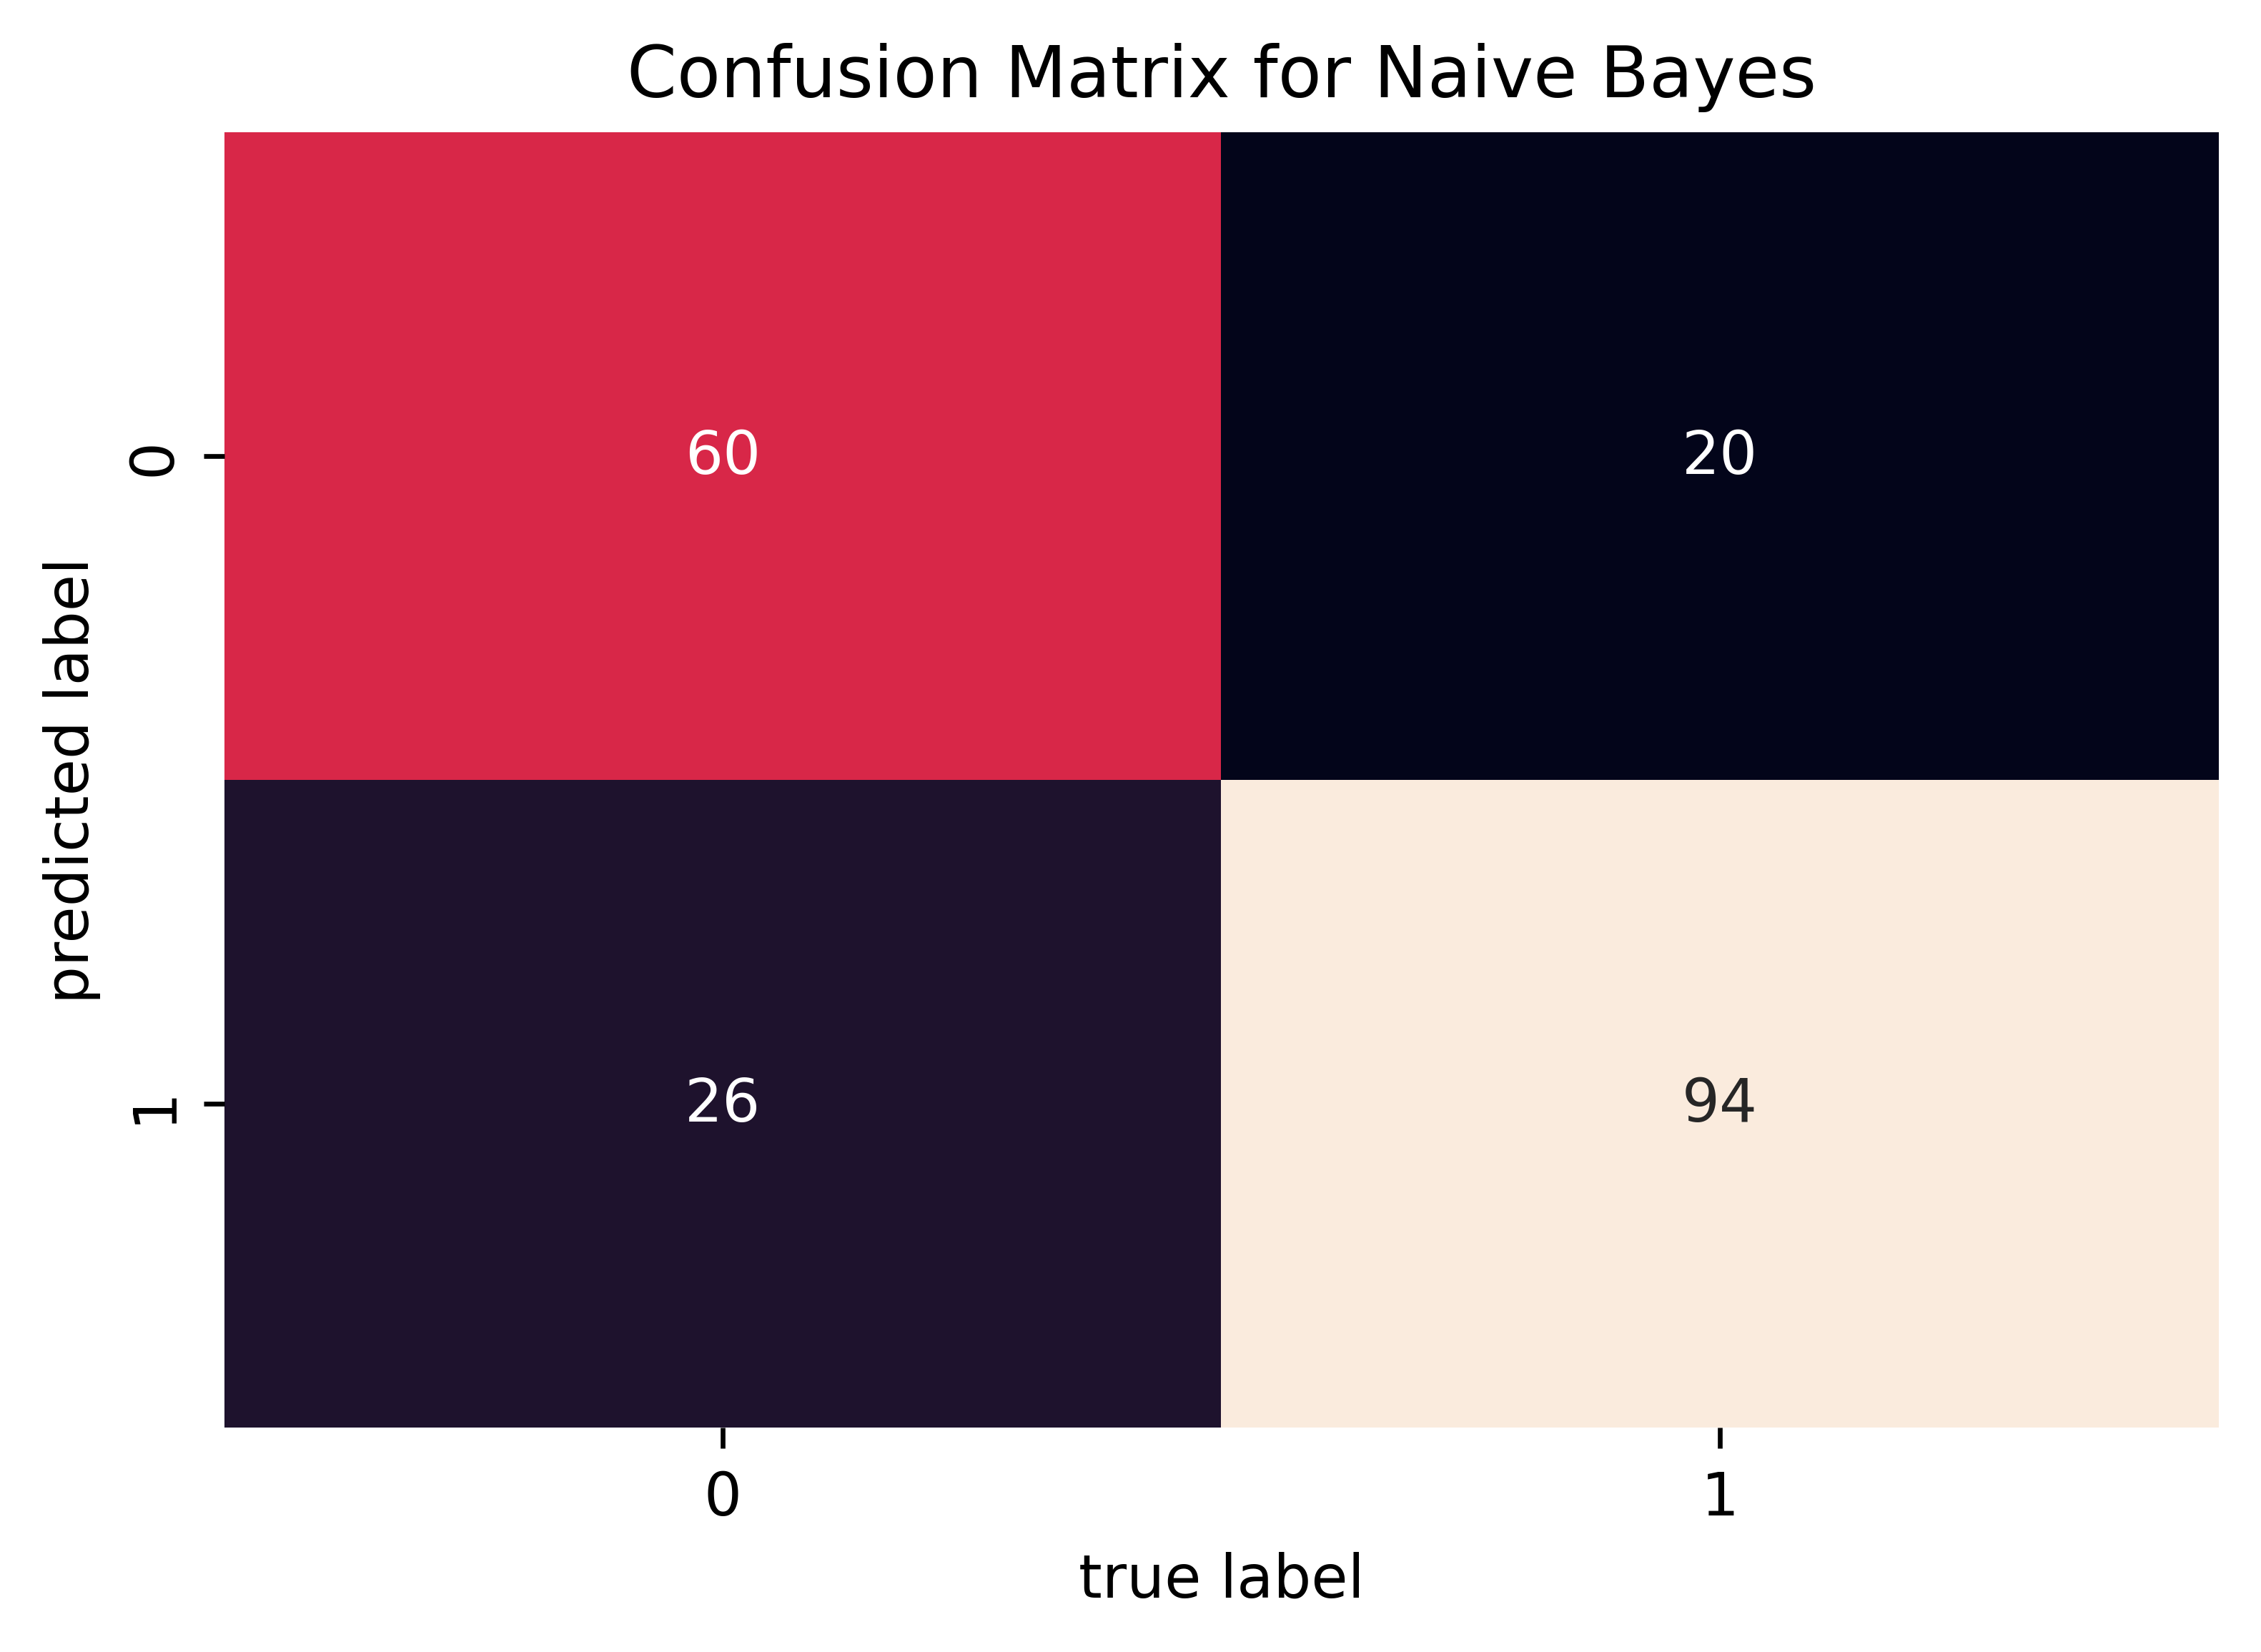

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=600)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.77


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive, digits=5))

              precision    recall  f1-score   support

           0    0.75000   0.69767   0.72289        86
           1    0.78333   0.82456   0.80342       114

    accuracy                        0.77000       200
   macro avg    0.76667   0.76112   0.76316       200
weighted avg    0.76900   0.77000   0.76879       200



# SVM

In [29]:
data_positive = df['new_text'].loc[df['label_id'] == 1]
data_negative = df['new_text'].loc[df['label_id'] == 0]
sample_size = min(data_positive.shape[0],data_negative.shape[0])
raw_data = np.concatenate((data_positive.values[:sample_size], data_negative.values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size

In [30]:
x_train,x_test,y_train,y_test = train_test_split(raw_data, labels, test_size=0.3, random_state=42)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

In [32]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])

Training time: 0.022226s; Prediction time: 0.003414s
positive:  {'precision': 0.6867469879518072, 'recall': 0.9047619047619048, 'f1-score': 0.7808219178082192, 'support': 126}
negative:  {'precision': 0.8681318681318682, 'recall': 0.6030534351145038, 'f1-score': 0.7117117117117118, 'support': 131}
